In [193]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.IDEC import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [195]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [120]:
# specify learning params
batch_size = 128
learning_rate = 0.001
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the pretrained RotNet model

In [103]:
def encode_batchwise(dataloader, model, device, layer, flatten=False):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        feats = model(batch_data, layer)
        if flatten:
            embeddings.append(feats.flatten(start_dim=1).detach().cpu())
        else:
            embeddings.append(feats.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [104]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR')
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [105]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [106]:
# for i in range(3):
model = RotNet(num_classes=4, num_blocks=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_e100.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'conv4', 'classifier']


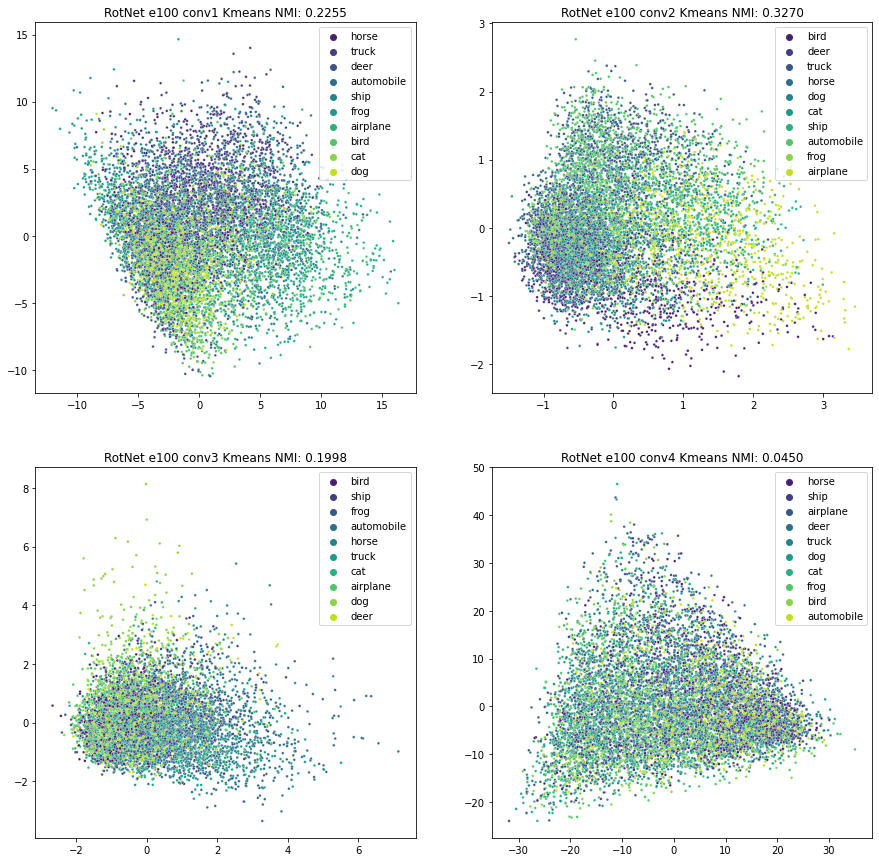

In [107]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()

for i, layer in enumerate(model.feat_block_names[:-1]):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

RotNet model has "Network in Network" structure, which means it consists of multiple "smaller" convolutional networks. Each convolutional block returns different features. I have tried to perform kmeans on each of the block, and 2d block showed the best results, so I took it's features for later IDEC training.

I have a question to the convolutional networks output: it returns me a list of different activations for an image (I have plotted the activations for one of the images below). To perform kmeans, I just flattened the vector and used the whole output. Is there a better way to use the convolutional network output for the IDEC? Probably some kind of dimensionality reduction? 

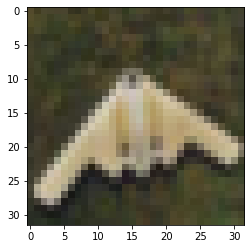

In [76]:
img, label = test_data.__getitem__(5)
plt.imshow(img.numpy().transpose(1,2,0))

In [77]:
img1 = img.unsqueeze(0).to(device)

img 5 conv1


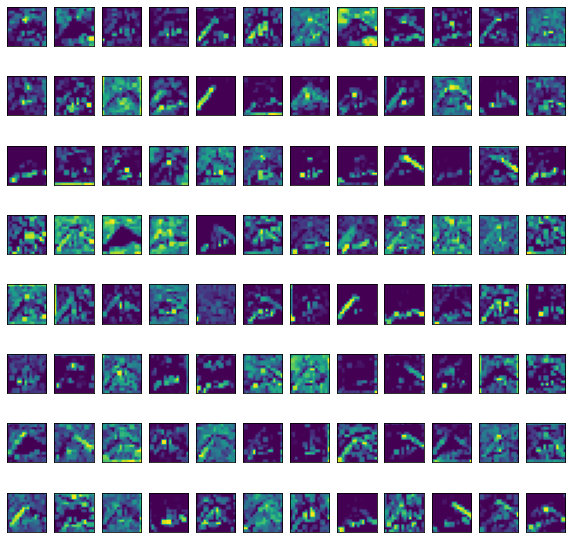

img 5 conv2


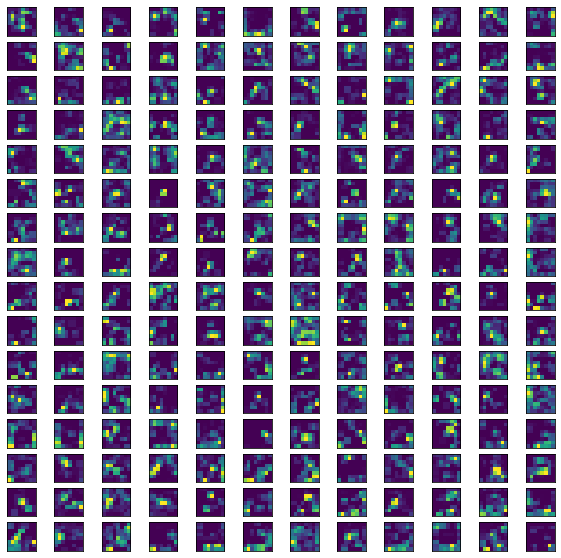

img 5 conv3


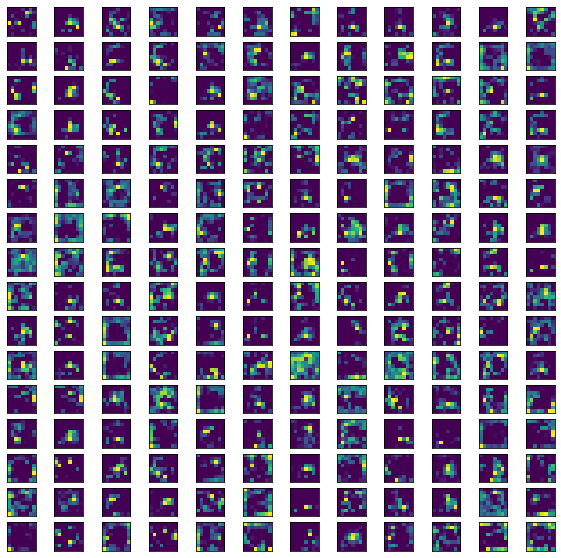

img 5 conv4


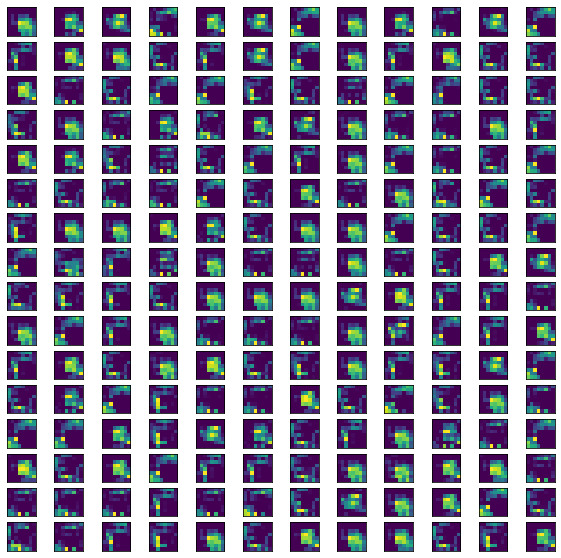

In [109]:
for i, layer in enumerate(model.feat_block_names[:-1]):
    print(f'img 5 {layer}')
    embedded_img = model(img1, [layer]).cpu().detach().numpy()[0]
    row_num = int(embedded_img.shape[0]/12)
    
    fig, axes = plt.subplots(row_num,12, figsize=(10,10))
    axes = axes.flatten()

    for i, img in enumerate(embedded_img):
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        axes[i].imshow(img)

    plt.show()

In [ ]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device):
    print(f"Training {model.name} started...")
    model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:
        # data_limit = int(len(data) * data_percent)
        # print(f"Number of train images: {data_limit}")
        print(f"Number of train images: {len(data)}")

        # trainloader = torch.utils.data.DataLoader(data[:data_limit],
        trainloader = torch.utils.data.DataLoader(data,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=True)

        model = model.fit(trainloader=trainloader, epochs=epochs, start_lr=learning_rate, device=device, model_path=pretrained_model_path)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model

In [226]:
vers = ['pretrained_RotNet', 'IDEC_RotNet_e30',
        'IDEC_RotNet_e30_1', 'IDEC_RotNet_e60',
        'IDEC_RotNet_e21']
pcas = {}
nmis = {}

In [227]:
for ver in vers:
    print(ver)
    if 'IDEC' not in ver:
        rotnet = RotNet(num_classes=4, num_blocks=4)
    else:
        rotnet = IDEC()

    state_dict = torch.load(f'trained_models/{ver}.pth', map_location='cpu')
    rotnet.load_state_dict(state_dict)
    rotnet.to(device)
    
    embedded_data, labels = idec_simclr.model.encode_batchwise(testloader, device, ['conv2'], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmis[ver] = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    pcas[ver] = pca.fit_transform(embedded_data)

pretrained_RotNet
IDEC_RotNet_e30


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_RotNet_e30_1


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_RotNet_e60


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_RotNet_e21


D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


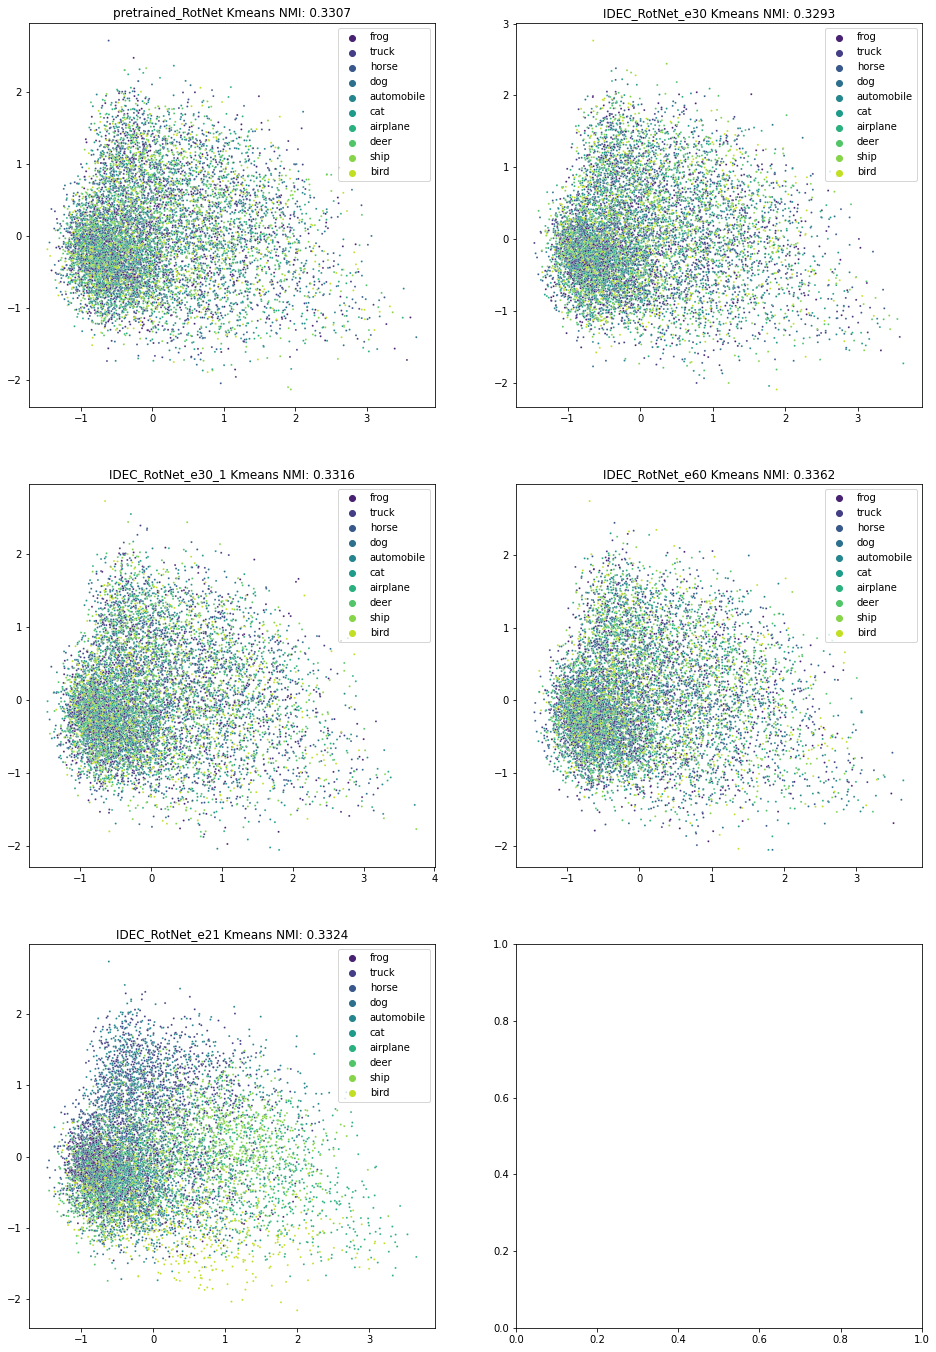

In [230]:
fig, axes = plt.subplots(3, 2, figsize=(16,24))
axes = axes.flatten()

for i, ver in enumerate(vers):
    axes[i].set_title(f'{ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=4, palette='viridis')

I feel like classification results here rely on kmeans and pca run heavily. E.g. the plot for pretrained RotNet looked better previously (in a group of plots for different conv blocks output) although I have used the same model.

pretrained_RotNet class representation


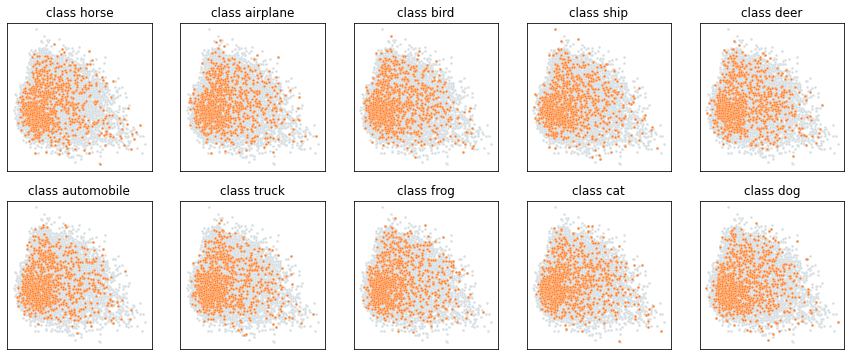

IDEC_RotNet_e30 class representation


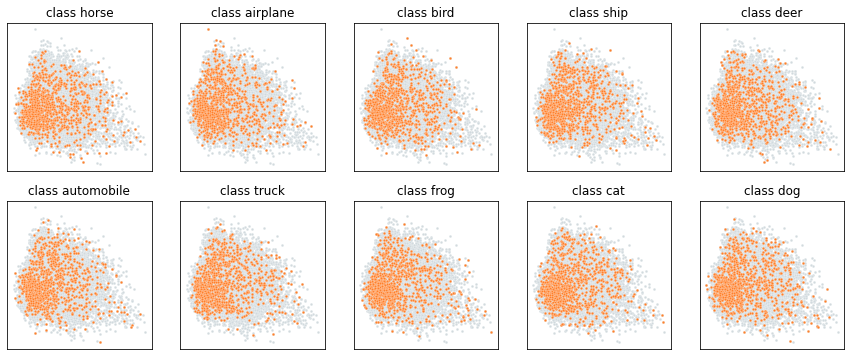

IDEC_RotNet_e30_1 class representation


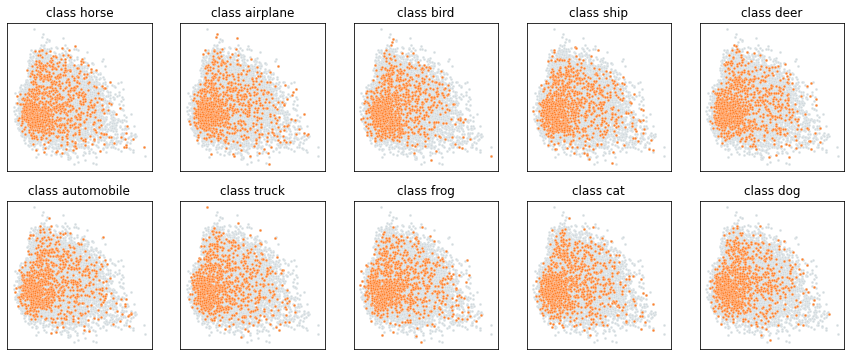

IDEC_RotNet_e60 class representation


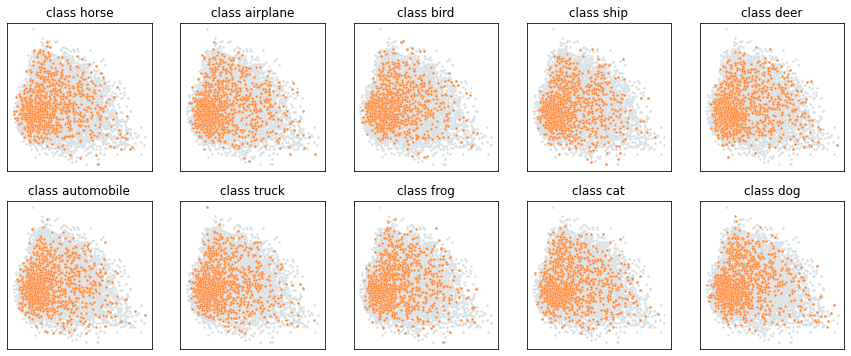

IDEC_RotNet_e21 class representation


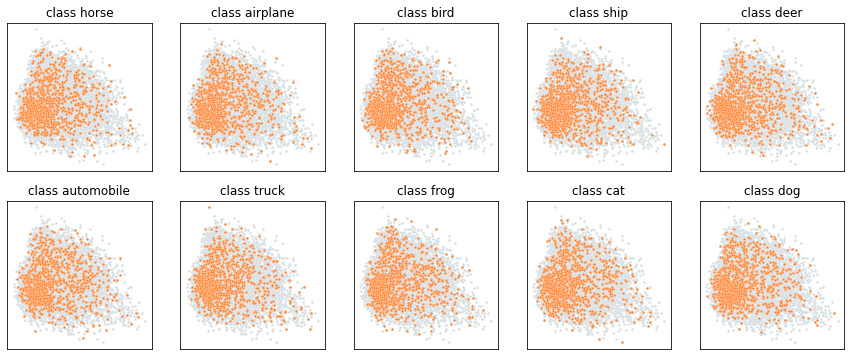

In [231]:
for ver in vers:
    print(f'{ver} class representation')
    fig, axes = plt.subplots(2,5, figsize=(15,6))
    axes = axes.flatten()

    for i, c in enumerate(set(lable_classes)):
        ids = np.where(lc==c)[0]
        axes[i].set(title=f'class {c}')
        axes[i].tick_params(bottom=False, left=False)
        axes[i].set(xticklabels=[], yticklabels=[])
        sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], s=7, color='#d1dade')  
        sns.scatterplot(ax=axes[i], x=pcas[ver][ids,0], y=pcas[ver][ids,1], s=7, color='#ff802b')

    plt.show()

In [215]:
model = RotNet(num_classes=4, num_blocks=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print('model loaded')

model loaded


In [216]:
data = load_util.load_custom_cifar('./data', download=False, data_percent=data_percent, for_model='RotNet')
trainloader = torch.utils.data.DataLoader(data,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=True)

In [217]:
cluster_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR')
clusterloader = torch.utils.data.DataLoader(cluster_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [218]:
embedded_data, labels = model.encode_batchwise(clusterloader, device=device, layer=['conv2'], flatten=True)
n_clusters = len(set(labels))
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(embedded_data)
nmi = normalized_mutual_info_score(labels, kmeans.labels_)
print(f"NMI: {nmi:.4f}")

NMI: 0.3256


In [224]:
loss = torch.nn.CrossEntropyLoss()
idec_rotnet = IDEC(model, loss, kmeans.cluster_centers_, device)
train_model(idec_simclr, batch_size, 0.001, 30, data, train, device)
print('Finished')

Training IDEC_RotNet started...
Number of train images: 80000
IDEC_RotNet: Epoch 1/30 - Iteration 625 - Train loss:0.2305, LR: 0.0001
IDEC_RotNet: Epoch 6/30 - Iteration 3750 - Train loss:0.2328, LR: 0.0001
IDEC_RotNet: Epoch 11/30 - Iteration 6875 - Train loss:0.2323, LR: 0.0001
IDEC_RotNet: Epoch 16/30 - Iteration 10000 - Train loss:0.2304, LR: 0.0001
IDEC_RotNet: Epoch 21/30 - Iteration 13125 - Train loss:0.2306, LR: 0.0001
IDEC_RotNet: Epoch 26/30 - Iteration 16250 - Train loss:0.2310, LR: 0.0001
Finished


In [222]:
def train_model(model, batch_size, learning_rate, epochs, data, train, device):
    print(f"Training {model.name} started...")
    model.to(device)

    # paths to save/load models from
    base_path = "trained_models"
    pretrained_model_name = f"pretrained_{model.name}.pth"
    pretrained_model_path = os.path.join(base_path, pretrained_model_name)

    # training
    if train:
        # data_limit = int(len(data) * data_percent)
        # print(f"Number of train images: {data_limit}")
        print(f"Number of train images: {len(data)}")

        # trainloader = torch.utils.data.DataLoader(data[:data_limit],
        trainloader = torch.utils.data.DataLoader(data,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  drop_last=True)

        model = model.fit(trainloader=trainloader, epochs=epochs, start_lr=learning_rate, device=device, model_path=pretrained_model_path)
        torch.save(model.state_dict(), pretrained_model_path)
    else:
        state_dict = torch.load(pretrained_model_path, map_location=device)
        model.load_state_dict(state_dict)

    return model